In [211]:
import os
import numpy as np
#np.random.seed(34)
#np.random.seed(2)
np.random.seed(25)
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

In [212]:
data_path = "Dataset/frontalimages_manuallyaligned_part1/"
selfie_path = "Dataset/selfie/"
smile_images = []
neutral_images = []

In [213]:
for file_name in os.listdir(data_path):
    if "a" in file_name:
        neutral_images.append(file_name)
    else:
        smile_images.append(file_name)

In [214]:
neutral_samples = np.random.choice(neutral_images, size=30, replace=False)
smile_samples = np.random.choice(smile_images, size=30, replace=False)

neutral_data = []
smile_data = []

In [215]:
for i in range(0,30):
    img = cv2.imread(data_path + neutral_samples[i])
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to gray scale
    neutral_data.append(gray_img)

    img = cv2.imread(data_path + smile_samples[i])
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to gray scale
    smile_data.append(gray_img)

img = cv2.imread(selfie_path + "neutral.jpg")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
neutral_data.append(gray_img)

img = cv2.imread(selfie_path + "smile.jpg")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
smile_data.append(gray_img)

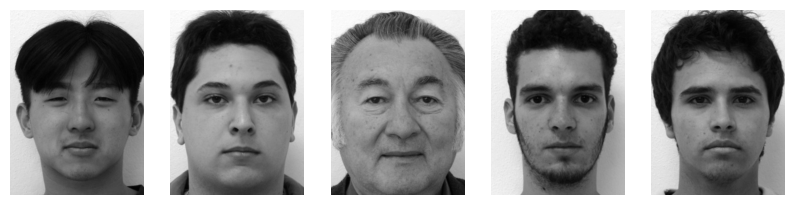

In [216]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))

# Plotando as imagens
for i, ax in enumerate(axes):
    ax.imshow(neutral_data[i], cmap='gray')
    ax.axis('off')

In [217]:
img_data = np.concatenate((neutral_data, smile_data))
img_labels = np.concatenate(([0]*(len(neutral_data)), [1]*(len(smile_data))))

In [218]:
# Vetorizar imagem
img_data = np.array([sample.flatten() for sample in img_data])

img_data.shape

(62, 93600)

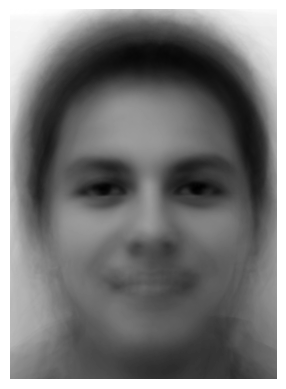

In [219]:
mean_face = img_data.mean(axis=0)
plt.imshow(mean_face.reshape(360,260),cmap='gray')
plt.axis('off')
plt.savefig("Results/MeanFace.png", bbox_inches='tight', pad_inches=0)

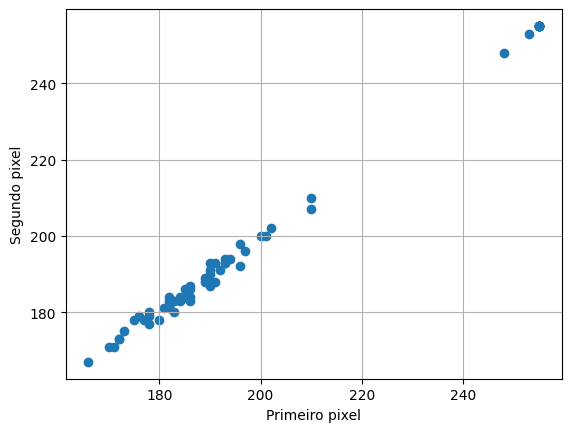

In [220]:
plt.scatter(img_data[:,0],img_data[:,1])
#plt.xlim([0, 255])
#plt.ylim([0, 255])
#plt.title("Análise dos primeiros pixels do dataset")
plt.xlabel('Primeiro pixel')
plt.ylabel('Segundo pixel')
plt.grid()
plt.savefig("Results/pixel_analysis.png")

# Principal Component Analysis (PCA)

In [221]:
# Subtrair da média
mean_img_data = (img_data - img_data.mean(axis=0))

In [222]:
pca = PCA(n_components=2).fit(mean_img_data)

In [223]:
pca.explained_variance_ratio_

array([0.32780845, 0.15260786])

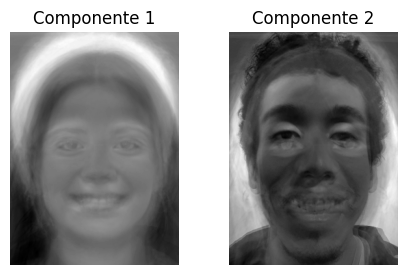

In [224]:
eigenvectors = pca.components_
f, axarr = plt.subplots(1,2, figsize=(5, 5))
for i in range(2):
    axarr[i].imshow(eigenvectors[i].reshape(360,260),cmap='gray')
    axarr[i].set_title(f'Componente {str(i+1)}')
    axarr[i].axis('off')

plt.subplots_adjust(top=1.1, wspace=0.3)

# Add a title for the entire figure
#f.suptitle("Autovetores de cada componente")
plt.savefig("Results/autovetores.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [225]:
pca_face_db = pca.transform(mean_img_data)
pca_face_db.shape

(62, 2)

In [226]:
normalized_pca = (pca_face_db - np.min(pca_face_db)) / (np.max(pca_face_db) - np.min(pca_face_db))

In [227]:
selfie_neutral = normalized_pca[30]
selfie_smile = normalized_pca[61]

index_neutral = 30
index_smile = 61
selfies_index = [30,61]

distances = np.linalg.norm(normalized_pca - selfie_neutral, axis=1)
distances[index_neutral:] = np.inf
closest_index_neutral = np.argmin(distances)
distances[index_neutral:] = -np.inf
farthest_index_neutral = np.argmax(distances)

distances = np.linalg.norm(normalized_pca - selfie_smile, axis=1)
distances[:index_neutral+1] = np.inf
distances[index_smile] = np.inf
closest_index_smile = np.argmin(distances)
distances[:index_neutral+1] = -np.inf
distances[index_smile] = -np.inf
farthest_index_smile = np.argmax(distances)

In [228]:
closest_index_neutral, farthest_index_neutral, ' ', closest_index_smile, farthest_index_smile

(20, 19, ' ', 51, 40)

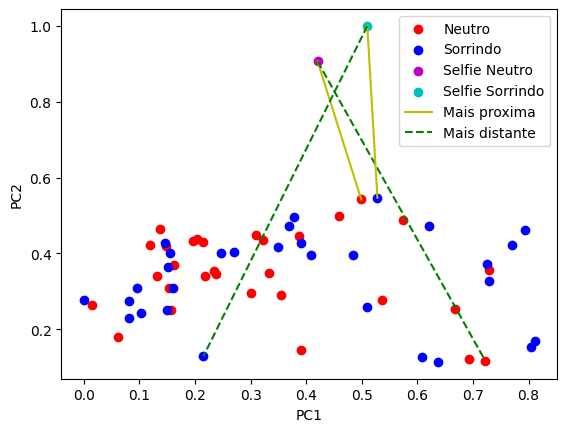

In [229]:
colors = ['r', 'b']

for i in range(len(colors)):
    x = normalized_pca[img_labels == i, 0]
    y = normalized_pca[img_labels == i, 1]
    plt.scatter(x[0:30], y[0:30], c=colors[i], label=i)

plt.scatter(selfie_neutral[0], selfie_neutral[1], c='m')
plt.scatter(selfie_smile[0], selfie_smile[1], c='c')

x_coords = [selfie_neutral[0], normalized_pca[closest_index_neutral][0]]
y_coords = [selfie_neutral[1], normalized_pca[closest_index_neutral][1]]
plt.plot(x_coords, y_coords, c='y')

x_coords = [selfie_neutral[0], normalized_pca[farthest_index_neutral][0]]
y_coords = [selfie_neutral[1], normalized_pca[farthest_index_neutral][1]]
plt.plot(x_coords, y_coords, linestyle='--', c='g')

x_coords = [selfie_smile[0], normalized_pca[closest_index_smile][0]]
y_coords = [selfie_smile[1], normalized_pca[closest_index_smile][1]]
plt.plot(x_coords, y_coords, c='y')

x_coords = [selfie_smile[0], normalized_pca[farthest_index_smile][0]]
y_coords = [selfie_smile[1], normalized_pca[farthest_index_smile][1]]
plt.plot(x_coords, y_coords, linestyle='--', c='g')

plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.title('2 Primeiras Componentes Principais')
plt.legend(["Neutro", "Sorrindo", "Selfie Neutro", "Selfie Sorrindo", "Mais proxima", "Mais distante"])

plt.savefig("Results/res_pca.png")

plt.show()

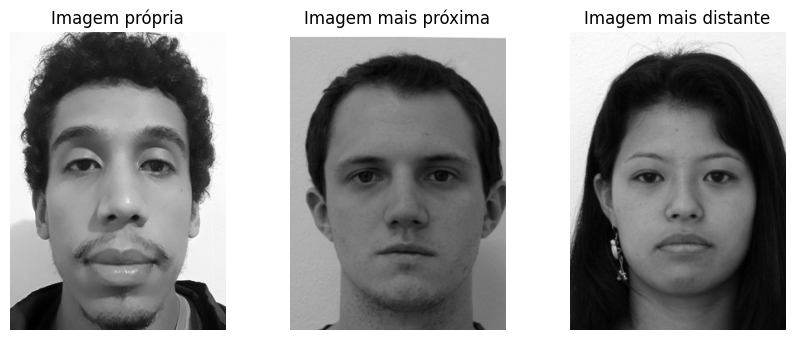

In [230]:
# Generate three random images
image_a = img_data[index_neutral].reshape(360,260)
image_b = img_data[closest_index_neutral].reshape(360,260)
image_c = img_data[farthest_index_neutral].reshape(360,260)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Display the first image in the first subplot with legend "A"
axs[0].imshow(image_a, cmap='gray')
axs[0].set_title("Imagem própria")

# Display the second image in the second subplot with legend "B"
axs[1].imshow(image_b, cmap='gray')
axs[1].set_title("Imagem mais próxima")

# Display the third image in the third subplot with legend "C"
axs[2].imshow(image_c, cmap='gray')
axs[2].set_title("Imagem mais distante")

# Adjust the vertical spacing between the subplots to decrease the distance between the main title and the images
plt.subplots_adjust(top=0.9, wspace=0.3)

# Add a title for the entire figure
#fig.suptitle("Comparação de imagens neutras no espaço de componentes principais")

for ax in axs:
    ax.axis("off")

# Display the figure
plt.savefig("Results/pca_neutral.png", bbox_inches='tight', pad_inches=0)
plt.show()


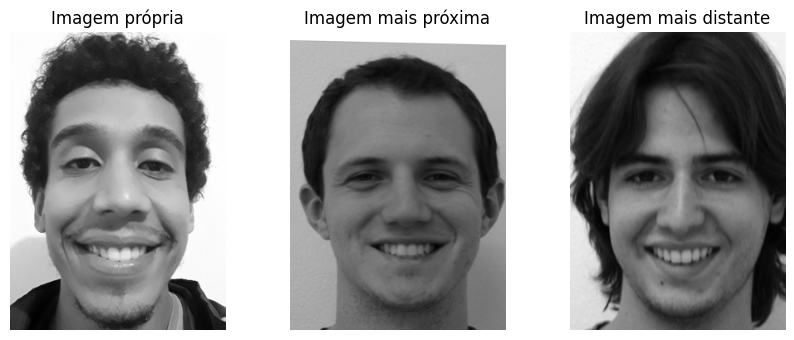

In [231]:
# Generate three random images
image_a = img_data[index_smile].reshape(360,260)
image_b = img_data[closest_index_smile].reshape(360,260)
image_c = img_data[farthest_index_smile].reshape(360,260)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Display the first image in the first subplot with legend "A"
axs[0].imshow(image_a, cmap='gray')
axs[0].set_title("Imagem própria")

# Display the second image in the second subplot with legend "B"
axs[1].imshow(image_b, cmap='gray')
axs[1].set_title("Imagem mais próxima")

# Display the third image in the third subplot with legend "C"
axs[2].imshow(image_c, cmap='gray')
axs[2].set_title("Imagem mais distante")

# Adjust the vertical spacing between the subplots to decrease the distance between the main title and the images
plt.subplots_adjust(top=0.9, wspace=0.3)

# Add a title for the entire figure
#fig.suptitle("Comparação de imagens sorrindo no espaço de componentes principais")

for ax in axs:
    ax.axis("off")

plt.savefig("Results/pca_smile.png", bbox_inches='tight', pad_inches=0)
# Display the figure
plt.show()


# PCA + MLDA

In [232]:
lda = LinearDiscriminantAnalysis(n_components=1)

In [233]:
# Fit the pipeline to the training data
X_transformed = lda.fit(normalized_pca, img_labels).transform(normalized_pca)

In [234]:
normalized_lda = (X_transformed - np.min(X_transformed)) / (np.max(X_transformed) - np.min(X_transformed))

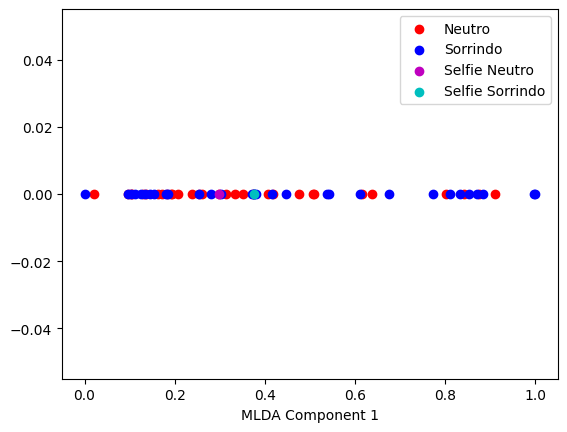

In [235]:
fig, ax = plt.subplots()
ax.scatter(normalized_lda[img_labels == 0, 0], [0]*len(normalized_lda[img_labels == 0, 0]), label='Neutro', c='r')
ax.scatter(normalized_lda[img_labels == 1, 0], [0]*len(normalized_lda[img_labels == 1, 0]), label='Sorrindo', c='b')

ax.scatter(normalized_lda[index_neutral], 0, c='m', label="Selfie Neutro")
ax.scatter(normalized_lda[index_smile], 0, c='c', label="Selfie Sorrindo")

ax.set_xlabel('MLDA Component 1')
#ax.set_ylabel('MLDA Component 2')
ax.legend()

plt.savefig("Results/res_mlda.png")

plt.show()

In [236]:
selfie_neutral = normalized_lda[30]
selfie_smile = normalized_lda[61]

index_neutral = 30
index_smile = 61
selfies_index = [30,61]

distances = np.linalg.norm(normalized_lda - selfie_neutral, axis=1)
distances[index_neutral:] = np.inf
closest_index_neutral = np.argmin(distances)
distances[index_neutral:] = -np.inf
farthest_index_neutral = np.argmax(distances)

distances = np.linalg.norm(normalized_lda - selfie_smile, axis=1)
distances[:index_neutral+1] = np.inf
distances[index_smile] = np.inf
closest_index_smile = np.argmin(distances)
distances[:index_neutral+1] = -np.inf
distances[index_smile] = -np.inf
farthest_index_smile = np.argmax(distances)

In [237]:
closest_index_neutral, farthest_index_neutral, ' ', closest_index_smile, farthest_index_smile

(28, 19, ' ', 53, 35)

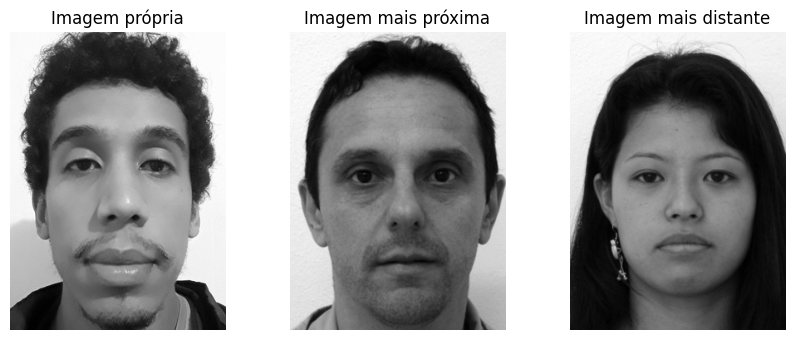

In [238]:
# Generate three random images
image_a = img_data[index_neutral].reshape(360,260)
image_b = img_data[closest_index_neutral].reshape(360,260)
image_c = img_data[farthest_index_neutral].reshape(360,260)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Display the first image in the first subplot with legend "A"
axs[0].imshow(image_a, cmap='gray')
axs[0].set_title("Imagem própria")

# Display the second image in the second subplot with legend "B"
axs[1].imshow(image_b, cmap='gray')
axs[1].set_title("Imagem mais próxima")

# Display the third image in the third subplot with legend "C"
axs[2].imshow(image_c, cmap='gray')
axs[2].set_title("Imagem mais distante")

# Adjust the vertical spacing between the subplots to decrease the distance between the main title and the images
plt.subplots_adjust(top=0.9, wspace=0.3)

# Add a title for the entire figure
#fig.suptitle("Comparação de imagens neutras no espaço de PCA+MLDA")

for ax in axs:
    ax.axis("off")

# Display the figure

plt.savefig("Results/mlda_neutral.png", bbox_inches='tight', pad_inches=0)

plt.show()


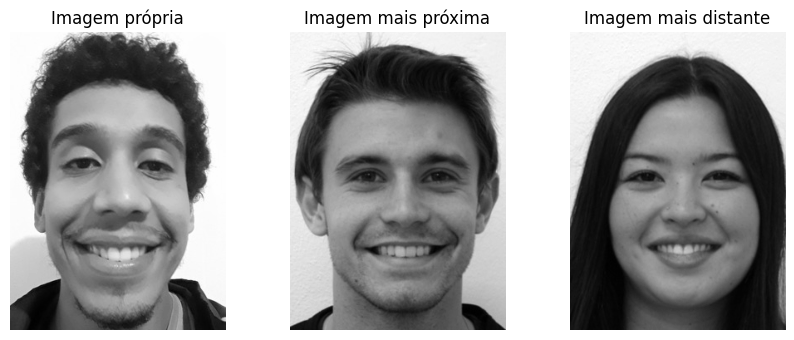

In [239]:
# Generate three random images
image_a = img_data[index_smile].reshape(360,260)
image_b = img_data[closest_index_smile].reshape(360,260)
image_c = img_data[farthest_index_smile].reshape(360,260)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Display the first image in the first subplot with legend "A"
axs[0].imshow(image_a, cmap='gray')
axs[0].set_title("Imagem própria")

# Display the second image in the second subplot with legend "B"
axs[1].imshow(image_b, cmap='gray')
axs[1].set_title("Imagem mais próxima")

# Display the third image in the third subplot with legend "C"
axs[2].imshow(image_c, cmap='gray')
axs[2].set_title("Imagem mais distante")

# Adjust the vertical spacing between the subplots to decrease the distance between the main title and the images
plt.subplots_adjust(top=0.9, wspace=0.3)

# Add a title for the entire figure
#fig.suptitle("Comparação de imagens sorrindo no espaço de PCA+MLDA")

for ax in axs:
    ax.axis("off")

plt.savefig("Results/mlda_smile.png", bbox_inches='tight', pad_inches=0)
# Display the figure
plt.show()
